# Computer vision-based analog meter reader

### 1. Import libraries

In [1]:
# Import necessary libraries and helper functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from helpers import imshow

### 2. Helper methods

In [2]:
# Method that generates a binary mask (using upper and lower boundaries in HSV color space)
def segment_image_hsv(image, min_HSV, max_HSV):
    # Convert image to HSV
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

    # create a mask and clean it up
    mask = cv2.inRange(hsv, min_HSV, max_HSV)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, None, iterations = 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, None, iterations = 5)
    mask = cv2.medianBlur(mask, 5)   
    return cv2.bitwise_not(mask)

In [3]:
# Helper function to find angle between vectors v1 and v2
def get_angle(v1, v2):
    v1 = v1 / np.linalg.norm(v1) # unit vector v1
    v2 = v2 / np.linalg.norm(v2) # unit vector v2
    cos_theta = np.dot(v1, v2) 
    return np.arccos(cos_theta)*(180/np.pi)

In [4]:
# Get sharpest peak in the contour whose k-curvature angle is smaller than thresh_angle.
def get_tip_index(samplePoints, thresh_angle, k):
    min_curv_angle = float('inf')
    tip_index = -1
    for j in range(len(samplePoints)):
        # determine points corresponding to indices j-k, j and j+k
        jCoord = samplePoints[j][0]
        minusK = samplePoints[(j-k)%len(samplePoints)][0]
        plusK = samplePoints[(j+k)%len(samplePoints)][0]
        kCurvAngle = get_angle(minusK - jCoord, plusK - jCoord)    
        if kCurvAngle <= thresh_angle and kCurvAngle < min_curv_angle:
            min_curv_angle = kCurvAngle
            orientation = np.cross(minusK - jCoord, plusK - jCoord)
            if orientation >= 0:
                tip_index = j
    return tip_index

In [5]:
# Calculate angle between an arrow and the negative horizontal axis.

# Idea: find a midpoint between C[tip_index-step] and C[tip_index+step] (where C is an array of 
# evenly spaced contour points). Next, find an angle between the midpoint-to-the-tip vector
# and the negative horizontal axis.

# For robustness, we do it for several different steps, and take median.
def get_arrow_angle(samplePoints, tip_index):
    angles = []
    # step is number of points away from the tip.
    for step in range(14, 22): 
        tip_coord = samplePoints[tip_index][0]
        plusK = samplePoints[(tip_index + step)%len(samplePoints)][0]
        minusK = samplePoints[(tip_index - step)%len(samplePoints)][0]
        mid_point = np.mean([minusK, plusK], axis=0).astype(int)

        orientation = np.cross([100, 0], mid_point - tip_coord) # whether cross product points up or down
        angle = np.sign(orientation) * get_angle([100, 0],  mid_point - tip_coord)*3.14/180.0
        angles.append(angle)
    median_angle = sorted(angles)[len(angles) / 2]
    return median_angle # angle in radians

In [6]:
# Draw orientation of the arrow on the image.
# Note: This method modifies image.
def draw_arrow_orientation(image, samplePoints, tip_index, angle, length):   
    
    # Point 1
    x1 = samplePoints[tip_index%len(samplePoints)][0][0] + 1* length * np.cos(angle)
    y1 = samplePoints[tip_index%len(samplePoints)][0][1] + 1* length * np.sin(angle)
    point1 = [int(x1), int(y1)]

    # Point 2
    x2 = samplePoints[tip_index%len(samplePoints)][0][0] - 3*length * np.cos(angle)
    y2 = samplePoints[tip_index%len(samplePoints)][0][1] - 3*length * np.sin(angle)
    point2 = [int(x2), int(y2)]    
    
    cv2.line(image, tuple(point1), tuple(point2), (0, 0, 255), 7)

In [7]:
# This method processes the contour of an arrow, and returns its angle with respect to the negative horizontal axis.
def from_arrow_cnt_to_angle(image, contour, thresh_angle, k, num_sample_poits):
    interval = len(contour)/num_sample_poits
    samplePoints = contour[0:len(contour):interval]

    # Draw a contour
    for index in range(len(samplePoints)):
        cv2.circle(image, tuple(samplePoints[index][0]), 3, (255, 255, 255), 2) 
    
    tip_index = get_tip_index(samplePoints, thresh_angle, k)
    if tip_index!=-1:
        angle = get_arrow_angle(samplePoints, tip_index)
        angle_degrees = angle*180.0/3.14
        draw_arrow_orientation(image, samplePoints, tip_index, angle, 100)
        jCoord = samplePoints[tip_index][0] # Draw arrow tip as blue circles
        cv2.circle(image, tuple(jCoord), 3, (255, 0, 0), 10)
        cv2.putText(image, str("%.1f"%angle_degrees), (jCoord[0], jCoord[1]-20), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), 5)
        return angle_degrees
    else: 
        return float('inf')


In [8]:
'''
Method for processing the top dials for a given segmentation threshold.
This method returns:
    "high" - if segmentation threshold is too high
    "low" - if segmentation threshold is too low
    Array of four angles (for four arrows) - if segmentation threshold is good enough
'''

def process_top_dials(seg_threshold, min_area, max_area, 
                      thresh_angle, k, num_sample_points):
    global top_dials
    # Get a binary mask and clean it up.
    retval, mask = cv2.threshold(top_dials_gray, seg_threshold, 255, cv2.THRESH_BINARY_INV )
    median = cv2.medianBlur(mask, 21)  
    mask = cv2.morphologyEx(median, cv2.MORPH_CLOSE, None, iterations = 6)
    mask = cv2.morphologyEx(median, cv2.MORPH_OPEN, None, iterations = 3)
    imshow(mask, "MASK")

    num_pixels = mask.size
    num_nonzero_pixels = cv2.countNonZero(mask)
    ratio = float(num_nonzero_pixels)/num_pixels
    print "Fraction of nonzero pixels:", ratio
    
    # Case 1: If ratio of nonzero pixels is too high, the threshold is too high.
    if ratio > 0.15:
        print "   threshold is too high"
        return "high"
    
    # Find contours of the binary mask and sort them by area
    _, contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Filter out the contours outside of the allowed area
    contours = [cnt for cnt in contours 
                if min_area <= cv2.contourArea(cnt) <= max_area]
    contours.sort(key = cv2.contourArea, reverse = True) # Sort by area
    
    # Check if the remaining contours contain four good contours.
    angles = []
    tmp = top_dials.copy()
    for i, cnt in enumerate(contours):
        angle = from_arrow_cnt_to_angle(tmp, cnt, thresh_angle, k, NUM_SAMPLE_POINTS_SMALL_ARROW)
        if angle == float('inf'):
            print "ARROW TIP NOT FOUND. Skipping this contour."
            imshow(tmp, "Arrow tip not found!")
            continue
        print "(searching ...) Angle {}: {}".format(i, "%.1f"%angle)
        angles.append((cnt, angle))
        
        # Case 2: If four good contours have been found, threshold is sufficiently good =>
        # => We can return four angles of the short arrows.
        if len(angles) == 4:
            # Return angles of arrows from left to right.
            angles.sort(key = lambda x: x[0][0][0][0])
            top_dials = tmp
            return [angle for cnt, angle in angles]
                      
    # Case 3: If four good contours haven't been found, threshold is too low.
    print "   threshold is too low"
    return "low"


### 3. Main code

****************************** 
STEP 1: LOOKING FOR THE METER ...


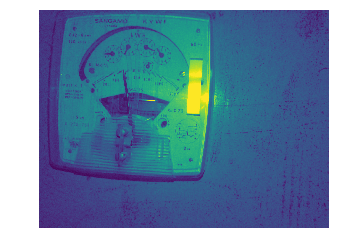

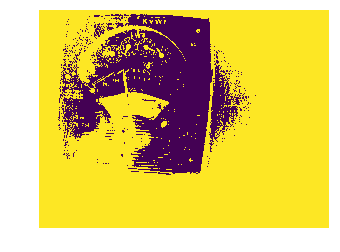

Tilt (base) angle of the meter: 4.3


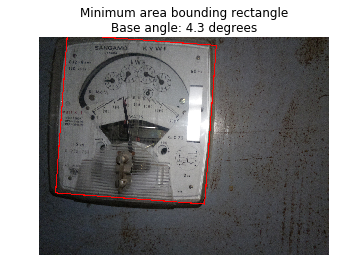

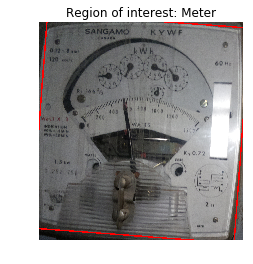

****************************** 
STEP 2: LOOKING FOR ANGLES OF THE SHORT ARROWS ...


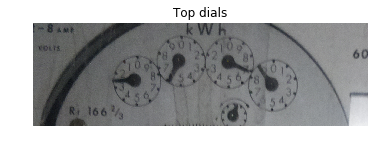

****************************** 
TRY THRESHOLD 127


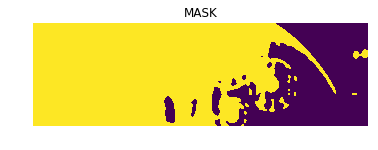

Fraction of nonzero pixels: 0.692973692974
   threshold is too high
****************************** 
TRY THRESHOLD 63


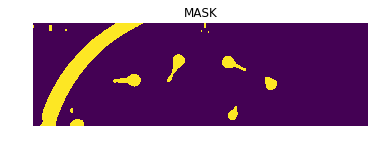

Fraction of nonzero pixels: 0.0848848121575
(searching ...) Angle 0: -3.0
(searching ...) Angle 1: -61.2
(searching ...) Angle 2: -152.8
   threshold is too low
****************************** 
TRY THRESHOLD 95


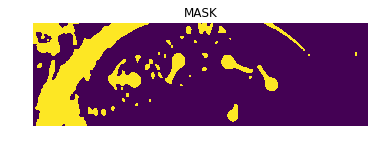

Fraction of nonzero pixels: 0.193473193473
   threshold is too high
****************************** 
TRY THRESHOLD 79


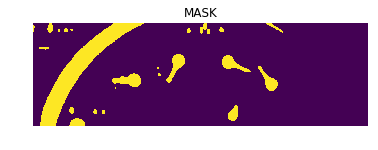

Fraction of nonzero pixels: 0.104683195592
(searching ...) Angle 0: 2.3
(searching ...) Angle 1: -62.7
(searching ...) Angle 2: -155.8
(searching ...) Angle 3: 55.3


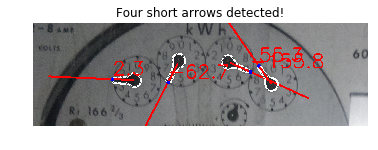



############################## 
##############################
FOUR GOOD ANGLES FOUND!
ANGLES OF THE SHORT ARROWS (FROM LEFT TO RIGHT):
   Angle 0: 2.3
   Angle 1: -62.7
   Angle 2: -155.8
   Angle 3: 55.3


ANGLES ADJUSTED W.R.T. THE BASE ANGLE (FROM LEFT TO RIGHT):
   Angle 0: -2.0
   Angle 1: -67.0
   Angle 2: -160.0
   Angle 3: 51.1
############################## 
############################## 




****************************** 
STEP 3: LOOKING FOR ANGLE OF THE LONG ARROW ...


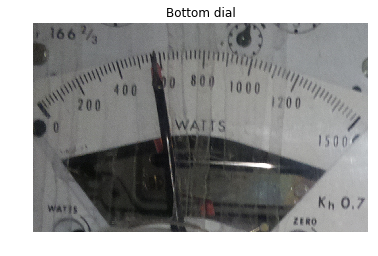

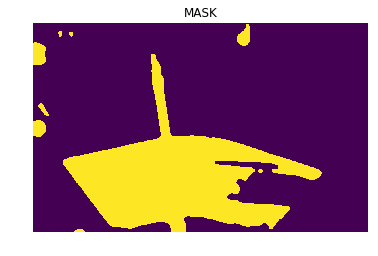



############################## 
##############################
ANGLE OF THE LOGN ARROW: 80.3
ANGLE OF THE LOGN ARROW ADJUSTED W.R.T. THE BASE ANGLE: 76.0
############################## 
############################## 




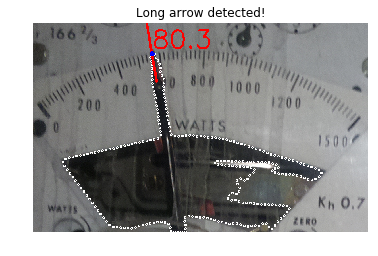

In [10]:
IMG_PATH ='sample-images/meter_type_2_1.jpg'

# CONSTANTS:
K = 10
THRESH_ANGLE = 50
NUM_SAMPLE_POINTS_SMALL_ARROW = 50
NUM_SAMPLE_POINTS_LONG_ARROW = 250
SMALL_ARROW_MIN_AREA = 3000
SMALL_ARROW_MAX_AREA = 6000

# =============================================================================
# STEP 1: Get the Region of Interest (ROI) and Find Tilt Angle of the Meter
# =============================================================================

print "*"*30, "\nSTEP 1: LOOKING FOR THE METER ..."
image = cv2.imread(IMG_PATH)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(gray)

retval, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
imshow(mask)
_, contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)
index = 1 # alternatively can use a range of reasonable areas
cnt = contours[index]

# Find Tilt Angle of the Meter
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
image = cv2.drawContours(image,[box],0,(0,0,255),6)
base_angle = get_angle([100, 0],  box[0] - box[1])
print "Tilt (base) angle of the meter:", "%.1f"%base_angle
imshow(image, "Minimum area bounding rectangle\nBase angle: {0:.1f} degrees".format(base_angle))

# Find ROI of the meter
x_min = min([pair[0][0] for pair in cnt])
x_max = max([pair[0][0] for pair in cnt])
y_min = min([pair[0][1] for pair in cnt])
y_max = max([pair[0][1] for pair in cnt])

meter_ROI = image[y_min:y_max, x_min:x_max] # Meter's ROI
imshow(meter_ROI, "Region of interest: Meter")

REF_METER_HEIGHT = 2100.0
scale = REF_METER_HEIGHT / len(meter_ROI)
meter_ROI = cv2.resize(meter_ROI, None, fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)
y_len, x_len = len(meter_ROI), len(meter_ROI[0])

# =============================================================================
# STEP 2: Get angles of small arrows
# =============================================================================

print "*"*30, "\nSTEP 2: LOOKING FOR ANGLES OF THE SHORT ARROWS ..."
# ROI:
y1, y2, x1, x2 = int(0.12*y_len), int(0.35*y_len), int(0.1*x_len), int(0.9*x_len)
top_dials = meter_ROI[y1:y2, x1:x2]
imshow(top_dials, "Top dials")
top_dials_gray = cv2.cvtColor(top_dials, cv2.COLOR_BGR2GRAY)

# Binary search to find a good segmentaiton threshold.
l, r = 0, 255
while r - l >= 0:
    mid = (l+r) / 2
    print "*"*30, "\n", "TRY THRESHOLD {}".format(mid)
    res = process_top_dials(mid, SMALL_ARROW_MIN_AREA, SMALL_ARROW_MAX_AREA, 
                           THRESH_ANGLE, K, NUM_SAMPLE_POINTS_SMALL_ARROW)
    if res == "low":
        l = mid+1
    elif res == "high":
        r = mid-1
    else:
        break
        
imshow(top_dials, "Four short arrows detected!")

print "\n\n", "#"*30, "\n", "#"*30
if res not in ["high", "low"]:
    print "FOUR GOOD ANGLES FOUND!"
    print "ANGLES OF THE SHORT ARROWS (FROM LEFT TO RIGHT):"
    for i, angle in enumerate(res):
        print "   Angle {}: {}".format(i, "%.1f"%angle)
        
    print "\n\nANGLES ADJUSTED W.R.T. THE BASE ANGLE (FROM LEFT TO RIGHT):"
    for i, angle in enumerate(res):
        print "   Angle {}: {}".format(i, "%.1f"%(angle - base_angle))
else:
    print "ANGLES NOT FOUND!"
print "#"*30, "\n", "#"*30, "\n\n" 

# =============================================================================
# STEP 3: Get angles of the long arrow
# =============================================================================

print "\n\n", "*"*30, "\nSTEP 3: LOOKING FOR ANGLE OF THE LONG ARROW ..."
y1, y2, x1, x2 = int(0.3*y_len), int(0.65*y_len), int(0.2*x_len), int(0.8*x_len)
bottom_dial = meter_ROI[y1:y2, x1:x2]
imshow(bottom_dial, "Bottom dial")

bottom_dial_gray = cv2.cvtColor(bottom_dial, cv2.COLOR_BGR2GRAY)
retval, mask = cv2.threshold(bottom_dial_gray, 75, 255, cv2.THRESH_BINARY_INV )
median = cv2.medianBlur(mask, 21)  
mask = cv2.morphologyEx(median, cv2.MORPH_CLOSE, None, iterations = 6)
mask = cv2.morphologyEx(median, cv2.MORPH_OPEN, None, iterations = 3)
imshow(mask, "MASK")

_, contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours.sort(key = cv2.contourArea, reverse = True) # Sort by area
large_arrow_cnt = contours[0]
angle = from_arrow_cnt_to_angle(bottom_dial, large_arrow_cnt, THRESH_ANGLE, K, NUM_SAMPLE_POINTS_LONG_ARROW)
print "\n\n", "#"*30, "\n", "#"*30
print "ANGLE OF THE LOGN ARROW: {}".format("%.1f"%angle)
print "ANGLE OF THE LOGN ARROW ADJUSTED W.R.T. THE BASE ANGLE: {}".format("%.1f"%(angle-base_angle))
print "#"*30, "\n", "#"*30, "\n\n" 
imshow(bottom_dial, "Long arrow detected!")

